In [ ]:
# Packages

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
from scipy.special import gamma
from scipy.optimize import least_squares

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from itertools import product

In [ ]:
# Training, Validation, and Testing Data using Numerical Solution with x, t, and u storage

L = 10.0  # Length of the domain
T = 1.0   # Total time
Nx = 500   # Number of spatial steps
Nt = 100   # Number of time steps
alpha = 0.45  # Fractional order of the derivative
kappa = 0.001  # Diffusion coefficient

dx = L / Nx
dt = T / Nt

# Initialize solution matrix
u = np.zeros((Nx+1, Nt+1))

# Initial condition
x = np.linspace(0, L, Nx+1)
t = np.linspace(0, T, Nt+1)
u[:, 0] = np.sin(np.pi * x)  # Example: u(x,0) = sin(pi*x)

# Coefficient for the fractional derivative (Grünwald-Letnikov approximation)
coeffs = [((-1)**k) * gamma(alpha+1) / (gamma(k+1) * gamma(alpha-k+1)) for k in range(Nt+1)]

# Time-stepping loop
for n in range(1, Nt+1):
    for i in range(1, Nx):
        fractional_derivative = np.dot(coeffs[:n+1], u[i, :n+1][::-1]) / dt**alpha
        u_xx = (u[i+1, n-1] - 2*u[i, n-1] + u[i-1, n-1]) / dx**2
        u[i, n] = dt**alpha * kappa * u_xx + fractional_derivative

# Data splitting ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate split indices
train_end = int(Nx * train_ratio)
val_end = train_end + int(Nx * val_ratio)

# Split the solution into training, validation, and testing datasets
train_data = u[:train_end, :]
val_data = u[train_end:val_end, :]
test_data = u[val_end:, :]

# Preprocessing: Standardization
mean = np.mean(train_data)
std = np.std(train_data)

train_data = (train_data - mean) / std
val_data = (val_data - mean) / std
test_data = (test_data - mean) / std

# Adjusted x and t for training, validation, and testing
x_train = x[:train_end]
x_val = x[train_end:val_end]
x_test = x[val_end:]
t_train = t
t_val = t
t_test = t



(350, 101) (75, 101) (76, 101)


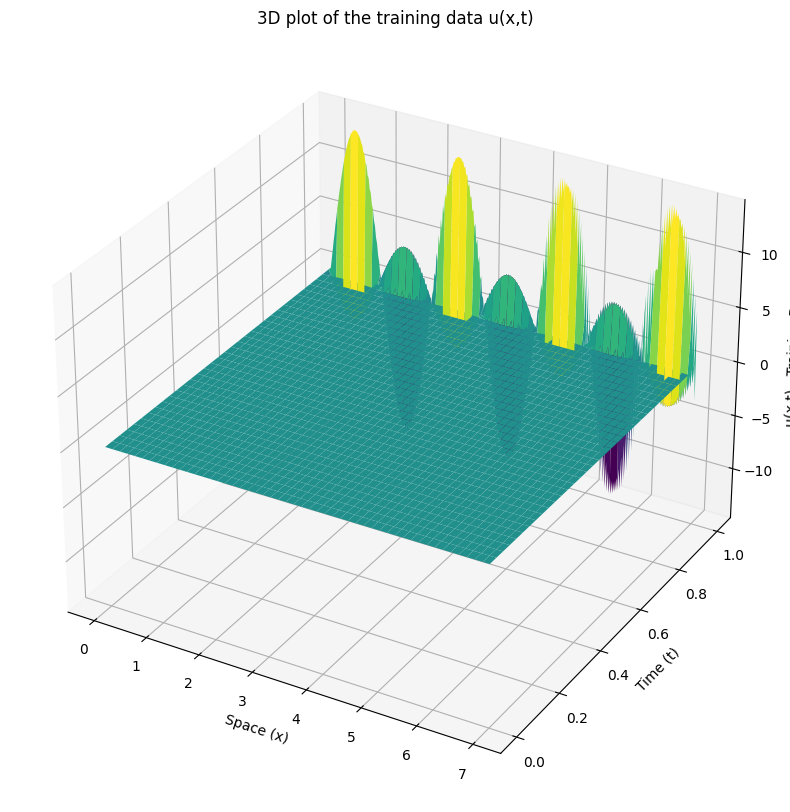

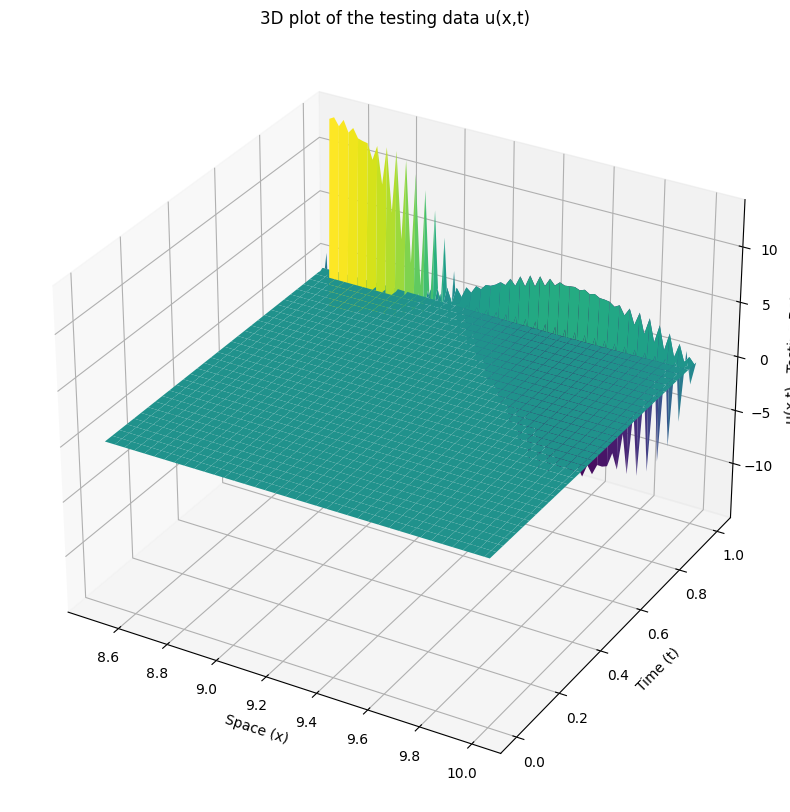

In [ ]:
# Visualization is omitted for brevity; you can plot the data similarly to the provided code.

print(train_data.shape, val_data.shape, test_data.shape)

# 3D plot for training data
X_train, T_train = np.meshgrid(x_train, t_train)
fig_train = plt.figure(figsize=(10,10))
ax_train = fig_train.add_subplot(111, projection='3d')
ax_train.plot_surface(X_train, T_train, train_data.T, cmap='viridis')
ax_train.set_xlabel('Space (x)')
ax_train.set_ylabel('Time (t)')
ax_train.set_zlabel('u(x,t) - Training Data')
ax_train.set_title('3D plot of the training data u(x,t)')

# 3D plot for testing data
X_test, T_test = np.meshgrid(x_test, t_train)
fig_test = plt.figure(figsize=(10,10))
ax_test = fig_test.add_subplot(111, projection='3d')
ax_test.plot_surface(X_test, T_test, test_data.T, cmap='viridis')
ax_test.set_xlabel('Space (x)')
ax_test.set_ylabel('Time (t)')
ax_test.set_zlabel('u(x,t) - Testing Data')
ax_test.set_title('3D plot of the testing data u(x,t)')

plt.show()

In [ ]:
# FNN Architecture

epochs=20

def fibonacci_polynomial(x, n):
    if n == 0:
        return 0
    elif n == 1:
        return 1
    else:
        a, b = 0, 1
        for _ in range(2, n + 1):
            a, b = b, x * b + a
        return b

def fibonacci_polynomial_derivative(x, n):
    if n == 0:
        return 0
    elif n == 1:
        return 0
    else:
        a, b = 0, 1
        da, db = 0, 0
        for _ in range(2, n + 1):
            a, b, da, db = b, x * b + a, db, x * db + b + da
        return db

np.random.seed(42)

# Define the Fibonacci Neural Network class
class FibonacciNeuralNetwork:
    def __init__(self, hidden_layer_size, lambda_l2=0.01):
        self.hidden_layer_size = hidden_layer_size
        self.lambda_l2 = lambda_l2
        self.weights_ih = np.random.randn(hidden_layer_size, 2) * np.sqrt(2. / hidden_layer_size)
        self.weights_ho = np.random.randn(1, hidden_layer_size) * np.sqrt(2. / hidden_layer_size)
        self.m_ih, self.v_ih = np.zeros_like(self.weights_ih), np.zeros_like(self.weights_ih)
        self.m_ho, self.v_ho = np.zeros_like(self.weights_ho), np.zeros_like(self.weights_ho)
        self.t = 0

    def feedforward(self, input_vector):
        hidden_values = np.array([
            fibonacci_polynomial(np.dot(input_vector, self.weights_ih[i]), i + 1)
            for i in range(self.hidden_layer_size)
        ])
        output = np.dot(self.weights_ho, hidden_values)
        return output[0]

    def compute_loss(self, predictions, targets):
        l2_penalty = self.lambda_l2 * (np.sum(self.weights_ih ** 2) + np.sum(self.weights_ho ** 2))
        return np.max(np.abs(predictions - targets)) + l2_penalty

    def compute_gradients(self, input_values, target_values):
        gradients_ih = np.zeros_like(self.weights_ih)
        gradients_ho = np.zeros_like(self.weights_ho)
        for input_vec, target in zip(input_values, target_values):
            hidden_values = np.array([
                fibonacci_polynomial(np.dot(input_vec, self.weights_ih[i]), i + 1)
                for i in range(self.hidden_layer_size)
            ])
            output = np.dot(self.weights_ho, hidden_values)
            error = output[0] - target
            for i in range(self.hidden_layer_size):
                df_dh = fibonacci_polynomial_derivative(np.dot(input_vec, self.weights_ih[i]), i + 1)
                dh_dw = input_vec * df_dh
                gradients_ih[i] += self.weights_ho[0, i] * error * dh_dw
            gradients_ho += hidden_values * error
        gradients_ih += 2 * self.lambda_l2 * self.weights_ih
        gradients_ho += 2 * self.lambda_l2 * self.weights_ho
        return gradients_ih, gradients_ho

    def adam_optimizer(self, weights, gradients, m, v, beta1=0.9,beta2=0.999,epsilon=1e-8,lr=0.001):
        self.t += 1
        m = beta1 * m + (1 - beta1) * gradients
        v = beta2 * v + (1 - beta2) * (gradients ** 2)
        m_hat = m / (1 - beta1 ** self.t)
        v_hat = v / (1 - beta2 ** self.t)
        weights_update = lr * m_hat / (np.sqrt(v_hat) + epsilon)
        return weights - weights_update, m, v

    def validate(self, val_input_values, val_target_values):
        predictions_val = [self.feedforward(input_vec) for input_vec in val_input_values]
        val_loss = self.compute_loss(predictions_val, val_target_values)
        return val_loss

    def train(self, train_input_values, train_target_values, val_input_values, val_target_values, lr, batch_size):
        train_losses = []
        val_losses = []
        for epoch in range(epochs):
            permutation = np.random.permutation(len(train_input_values))
            train_input_values_shuffled = train_input_values[permutation]
            train_target_values_shuffled = train_target_values[permutation]

            for i in range(0, len(train_input_values), batch_size):
                input_values_batch = train_input_values_shuffled[i:i+batch_size]
                target_values_batch = train_target_values_shuffled[i:i+batch_size]

                gradients_ih, gradients_ho = self.compute_gradients(input_values_batch, target_values_batch)
                self.weights_ih, self.m_ih, self.v_ih = self.adam_optimizer(self.weights_ih, gradients_ih, self.m_ih, self.v_ih, lr)
                self.weights_ho, self.m_ho, self.v_ho = self.adam_optimizer(self.weights_ho, gradients_ho, self.m_ho, self.v_ho, lr)

                predictions_batch = [self.feedforward(input_vec) for input_vec in input_values_batch]
                train_loss = self.compute_loss(predictions_batch, target_values_batch)
                train_losses.append(train_loss)

            val_loss = self.validate(val_input_values, val_target_values)
            val_losses.append(val_loss)

            print(f"Epochs {epoch + 1}, Train Loss: {train_loss}, Validation Loss: {val_loss}")
        return train_losses, val_losses

In [ ]:
# Training Model for different hypreparameters eventually finding best hyperparameters \

X_train, T_train = np.meshgrid(x_train, t_train)
X_val, T_val = np.meshgrid(x_val, t_val)
X_test, T_test = np.meshgrid(x_test, t_test)

input_values_train = np.column_stack((X_train.ravel(), T_train.ravel()))
target_values_train = train_data.flatten()
input_values_val = np.column_stack((X_val.ravel(), T_val.ravel()))
target_values_val = val_data.flatten()

# if __name__ == "__main__":

#     # Manually defined hyperparameters for exploration
#     hidden_layer_sizes = [5, 10, 15]  # Different sizes to test
#     learning_rates = [0.001, 0.005, 0.01]  # Different learning rates to test
#     batch_sizes = [20, 50, 100]  # Different batch sizes to test

#     # Best hyperparameter tracker
#     best_performance = float('inf')
#     best_hyperparameters = {}

#     # Iterate over all combinations of hyperparameters
#     for hidden_layer_size, learning_rate, batch_size in product(hidden_layer_sizes, learning_rates, batch_sizes):
#         print(f"Testing with: HLS={hidden_layer_size}, LR={lr}, BS={batch_size}")
#         fnn = FibonacciNeuralNetwork(hidden_layer_size=hidden_layer_size)
#         train_losses, val_losses = fnn.train(input_values_train, target_values_train, input_values_val, target_values_val, lr=learning_rate, batch_size=batch_size)
#         mean_val_loss = np.mean(val_losses)

#         # Update best hyperparameters if current combination is better
#         if mean_val_loss < best_performance:
#             best_performance = mean_val_loss
#             best_hyperparameters = {
#                 'hidden_layer_size': hidden_layer_size,
#                 'lr': lr,
#                 'batch_size': batch_size
#             }

#     print("Best Hyperparameters:", best_hyperparameters)

best_hyperparameters = {
                'hidden_layer_size': 10,
                'lr': 0.001,
                'batch_size': 50
            }

Epochs 1, Train Loss: 918.5418139562377, Validation Loss: 22314.073809074853
Epochs 2, Train Loss: 190.88096045522136, Validation Loss: 7150.823168478329
Epochs 3, Train Loss: 243.34971800373748, Validation Loss: 5933.3532238448015
Epochs 4, Train Loss: 169.65421545515926, Validation Loss: 5090.681670795896
Epochs 5, Train Loss: 141.58914597002698, Validation Loss: 5022.065158298355
Epochs 6, Train Loss: 250.28827587753324, Validation Loss: 4478.819591898241
Epochs 7, Train Loss: 182.43720122569175, Validation Loss: 4495.305822872959
Epochs 8, Train Loss: 91.91325132046151, Validation Loss: 3540.3076857543997
Epochs 9, Train Loss: 97.35854953808429, Validation Loss: 3766.8785521710033
Epochs 10, Train Loss: 71.76301177986002, Validation Loss: 3091.002777549429
Epochs 11, Train Loss: 55.829401301314, Validation Loss: 2673.635995184714
Epochs 12, Train Loss: 263.42763076788003, Validation Loss: 1178.0141550670005
Epochs 13, Train Loss: 90.64255875468098, Validation Loss: 1647.27704292834

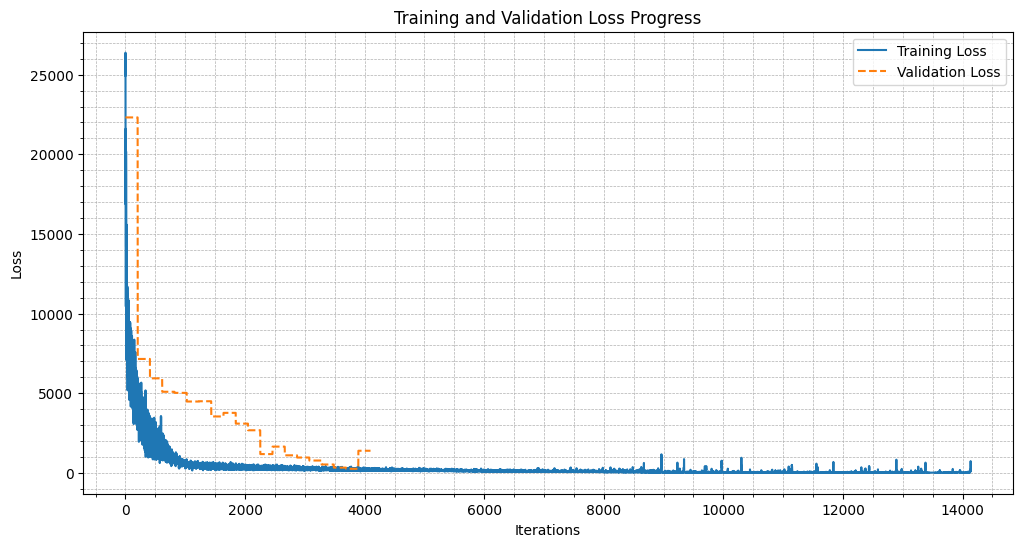

In [ ]:
# Training nn using best hyperparameters and then visualizing the result

def visualize_training_process(train_losses, val_losses, interval):
    fig, ax = plt.subplots(figsize=(12, 6))  # Create figure and axes

    # Plot training loss
    ax.plot(train_losses, label='Training Loss')

    # Expand the validation losses to match the number of training losses
    expanded_val_losses = [val_loss for val_loss in val_losses for _ in range(interval)]
    # Ensure that the length is not greater than train_losses due to the last incomplete set
    expanded_val_losses = expanded_val_losses[:len(train_losses)]

    # Plot validation loss
    ax.plot(expanded_val_losses, label='Validation Loss', linestyle='--')

    ax.set_xlabel('Iterations')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Validation Loss Progress')
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.minorticks_on()
    plt.show()

# Training
fnn = FibonacciNeuralNetwork(hidden_layer_size=best_hyperparameters['hidden_layer_size'])
train_losses, val_losses = fnn.train(input_values_train, target_values_train,
                                     input_values_val, target_values_val,
                                     lr=best_hyperparameters['lr'],
                                     batch_size=best_hyperparameters['batch_size'])
interval = 205
visualize_training_process(train_losses, val_losses, interval)

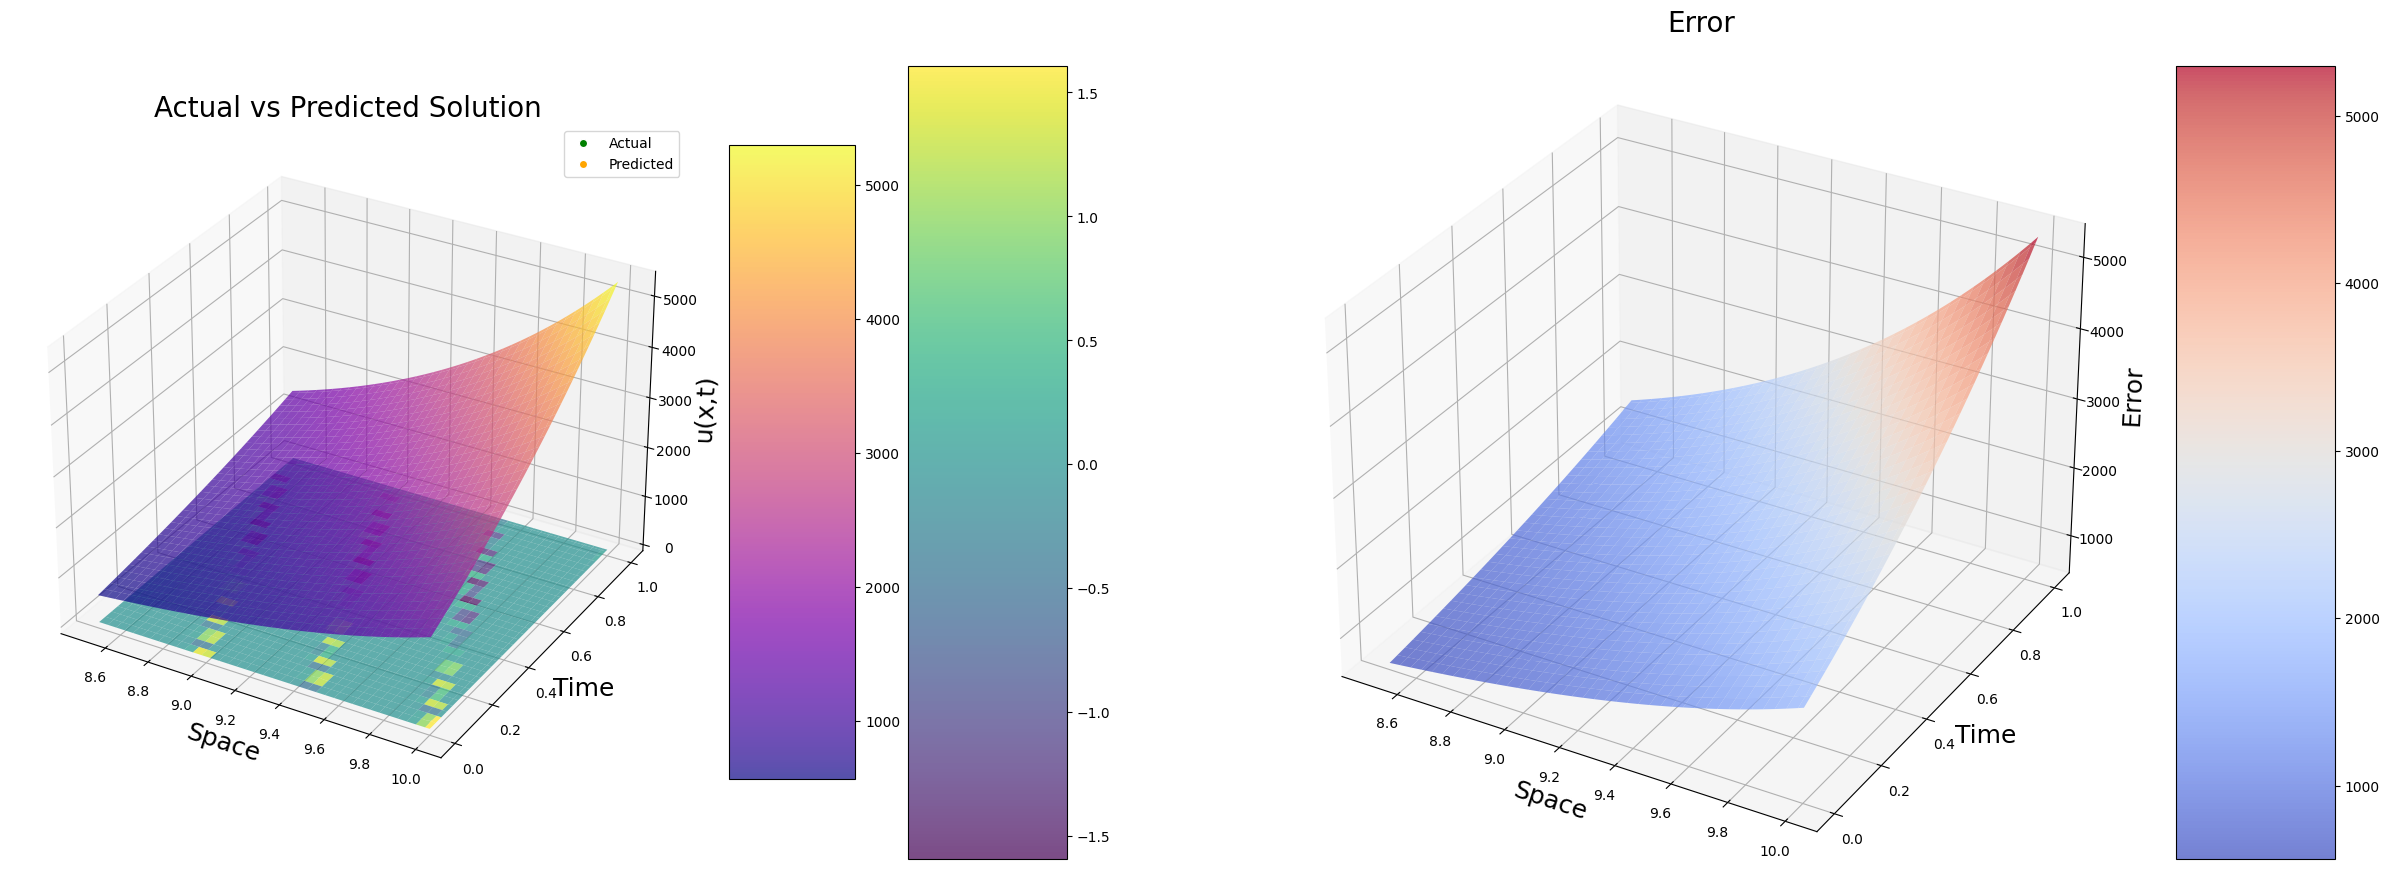

In [ ]:
# Testing nn using test data then visualize the result

def compare_predictions(X, T, actual, predicted):
    # Ensure actual and predicted are 2D arrays matching X and T's shape
    actual_2d = actual.reshape(X.shape)
    predicted_2d = predicted.reshape(X.shape)

    # Create a figure with two 3D subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,30), subplot_kw={"projection": "3d"})

    # Plot the actual surface with a green-blue colormap
    surf1 = ax1.plot_surface(X, T, actual_2d, cmap='viridis', edgecolor='none', alpha=0.7)
    # Add a color bar for the actual surface to indicate value scale
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

    # Plot the predicted surface with a red-yellow colormap
    surf2 = ax1.plot_surface(X, T, predicted_2d, cmap='plasma', edgecolor='none', alpha=0.7)
    # Add a color bar for the predicted surface to indicate value scale
    fig.colorbar(surf2, ax=ax1, shrink=0.5, aspect=5)

    # Set titles and labels for the first subplot
    ax1.set_title('Actual vs Predicted Solution', fontsize=20)
    ax1.set_xlabel('Space', fontsize=18)
    ax1.set_ylabel('Time', fontsize=18)
    ax1.set_zlabel('u(x,t)', fontsize=18)
    # Create custom legend entries for 3D plot surfaces
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='g', label='Actual'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', label='Predicted')]
    ax1.legend(handles=legend_elements, loc="upper right")

    # Calculate the error between the actual and predicted
    error = np.abs(actual_2d - predicted_2d)
    # Plot the error surface with a blue-red colormap
    surf3 = ax2.plot_surface(X, T, error, cmap='coolwarm', edgecolor='none', alpha=0.7)
    # Add a color bar for the error surface to indicate value scale
    fig.colorbar(surf3, ax=ax2, shrink=0.5, aspect=5)

    # Set titles and labels for the second subplot
    ax2.set_title('Error', fontsize=20)
    ax2.set_xlabel('Space', fontsize=18)
    ax2.set_ylabel('Time', fontsize=18)
    ax2.set_zlabel('Error', fontsize=18)

    # Display the plots
    plt.show()


# Testing
input_values_test = np.column_stack((X_test.ravel(), T_test.ravel()))
target_values_test = test_data.flatten()
predicted_values_test = np.array([fnn.feedforward(np.array([x, t])) for x, t in input_values_test])

# Comparison
compare_predictions(X_test, T_test, target_values_test, predicted_values_test)